# Real Estate Price Prediction

https://www.kaggle.com/c/real-estate-price-prediction-moscow

## 0. Libraries and settings

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats
import warnings

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

In [3]:
from scipy.stats.kde import gaussian_kde
from numpy import linspace
import pylab

In [4]:
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
warnings.filterwarnings("ignore")

In [5]:
title_font = {
    "fontsize": 16,
    "fontweight": "bold",
    "color": "#808080",
    "family": "serif"}

In [6]:
label_font = {
    "fontsize": 14,
    "family": "serif"}

In [7]:
legend_font = {
    "size": 14,
    "family": "serif"}

## 1. Upload data

In [8]:
os.chdir(r'C:\Data\GB\Python_Numpy\0_Real_estate')

In [9]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [10]:
train_ID = train['Id']
test_ID = test['Id']

train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

##### Data fields
- Price - Flat price
- Id - Flat ID
- DistrictId - District ID
- Rooms - Q-ty of rooms
- Square - Total square
- LifeSquare - Life Square
- KitchenSquare - Kitchen Square
- Floor - Flat Floor 
- HouseFloor - Q-ty of floors in house
- HouseYear - Year when hiuse was built
- Ecology_1, Ecology_2, Ecology_3 - Ecological indicators of territory
- Social_1, Social_2, Social_3 - Social indicators of territory
- Healthcare_1, Helthcare_2 - Healthcare indicators of territory
- Shops_1, Shops_2 - Shopping indicators of territory


### 2. Exploratory Data Analysis

### Target Variable

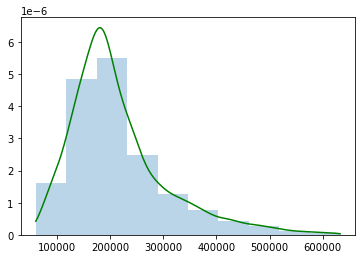

In [11]:
my_density = gaussian_kde(train.Price)
x = linspace(min(train.Price), max(train.Price), 1000)

pylab.plot(x, my_density(x), 'g')
pylab.hist(train.Price, density=1, alpha=0.3) # 
pylab.show()

mu = 214138.86 and sigma = 92867.65


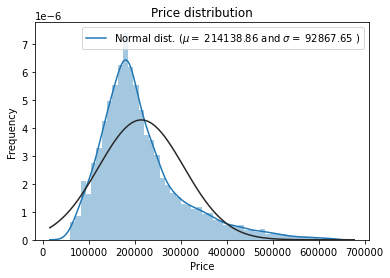

In [12]:
sns.distplot(train.Price, fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train.Price)
print( 'mu = {:.2f} and sigma = {:.2f}'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')

plt.ylabel('Frequency')
plt.title('Price distribution');

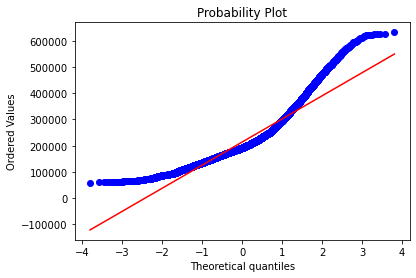

In [13]:
# QQ-plot
fig = plt.figure()
res = stats.probplot(train.Price, plot=plt)
plt.show();

The target variable is right skewed. As (linear) models love normally distributed data , we need to transform this variable and make it more normally distributed.

###### Log-transformation of the target variable

In [14]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train.Price = np.log1p(train.Price)

mu = 12.19 and sigma = 0.41


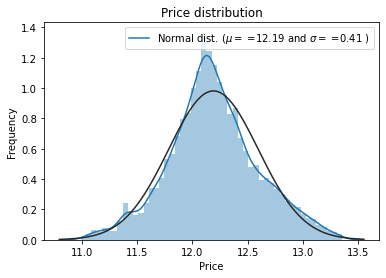

In [15]:
#Check the new distribution 
sns.distplot(train.Price, fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train.Price)
print( 'mu = {:.2f} and sigma = {:.2f}'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ ={:.2f} and $\sigma=$ ={:.2f} )'.format(mu, sigma)], loc='best')

plt.ylabel('Frequency')
plt.title('Price distribution');

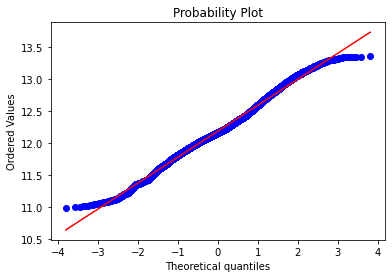

In [16]:
# QQ-plot
fig = plt.figure()
res = stats.probplot(train.Price, plot=plt)
plt.show();

The skew seems now corrected and the data appears more normally distributed.

### Predictors

In [17]:
# Combine Train & Test
ntrain = train.shape[0]
price = train.Price
df = pd.concat((train, test)).reset_index(drop=True)
df.drop('Price', axis=1, inplace=True)
print(f"all_data size: {df.shape}")

all_data size: (15000, 18)


###### Missing Data

In [18]:
df_na = (df.isnull().sum() / len(df)) * 100
fulldata_column_index = df_na[df_na == 0].index
df_na = df_na.drop(fulldata_column_index).sort_values(ascending=False)
#missing_data = pd.DataFrame({'Missing Ratio' : df_na})

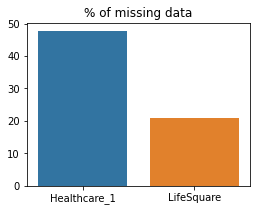

In [19]:
f, ax = plt.subplots(figsize=(4, 3))
sns.barplot(x=df_na.index, y=df_na)
plt.title('% of missing data');

## Data cleaning

In [20]:
df[['Rooms', 'HouseFloor']] = df[['Rooms', 'HouseFloor']].astype('int')

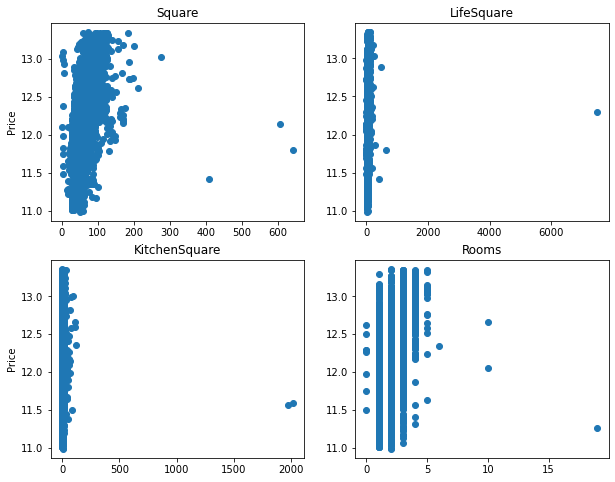

In [21]:
fig, ((ax1,ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(10,8))

ax1.scatter(x = train.Square, y = train.Price)
ax1.set_ylabel('Price')
ax1.set_title('Square')

ax2.scatter(x = train.LifeSquare, y = train.Price)
ax2.set_title('LifeSquare')

ax3.set_ylabel('Price')
ax3.scatter(x = train.KitchenSquare, y = train.Price)
ax3.set_title('KitchenSquare')

ax4.scatter(x = train.Rooms, y = train.Price)
ax4.set_title('Rooms');

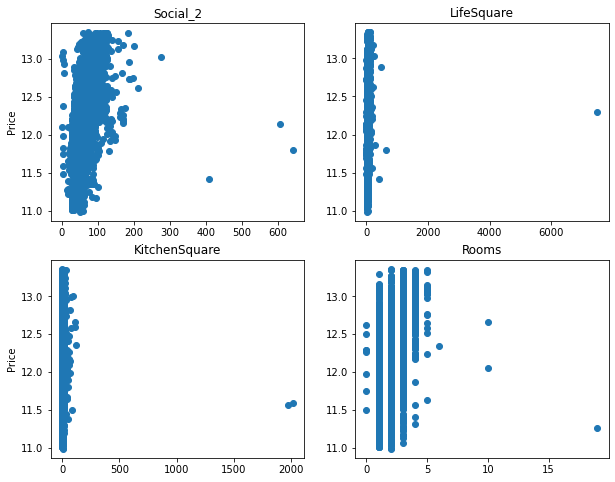

In [22]:
fig, ((ax1,ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(10,8))

ax1.scatter(x = train.Square, y = train.Price)
ax1.set_ylabel('Price')
ax1.set_title('Social_2')

ax2.scatter(x = train.LifeSquare, y = train.Price)
ax2.set_title('LifeSquare')

ax3.set_ylabel('Price')
ax3.scatter(x = train.KitchenSquare, y = train.Price)
ax3.set_title('KitchenSquare')

ax4.scatter(x = train.Rooms, y = train.Price)
ax4.set_title('Rooms');

In [23]:
df.loc[df.Square>250, 'Square'] = df.Square.median()
df.loc[df.LifeSquare>200, 'LifeSquare'] = df.LifeSquare.median()
df.loc[df.KitchenSquare>25, 'KitchenSquare'] = df.KitchenSquare.median()
df.loc[df.Rooms>7.5, 'Rooms'] = df.Rooms.median()

### 1) KitchenSquare  vs  Square

In [24]:
print('Qty of records where _ KitchenSquare > Square:', len(df[df.KitchenSquare > df.Square]))

Qty of records where _ KitchenSquare > Square: 0


In [25]:
df.loc[df.KitchenSquare > df.Square, 'KitchenSquare'] = df.loc[df.KitchenSquare > df.Square, 'Square']

In [26]:
print('Qty of records where _ KitchenSquare > Square:', len(df[df.KitchenSquare > df.Square]))

Qty of records where _ KitchenSquare > Square: 0


### 2.     LifeSquare + KitchenSquare   >   Square

##### Guess:
If Life square + Kitchen square > Total square => Life Square is incorrect

In [27]:
print('Qty of records where _ LifeSquare + KitchenSquare > Square:', len(df[(df.LifeSquare + df.KitchenSquare) > df.Square]))

Qty of records where _ LifeSquare + KitchenSquare > Square: 1257


In [28]:
df.loc[(df.LifeSquare + df.KitchenSquare) > df.Square, 'LifeSquare'] = \
df.loc[(df.LifeSquare + df.KitchenSquare) > df.Square, 'Square'] - \
df.loc[(df.LifeSquare + df.KitchenSquare) > df.Square, 'KitchenSquare']

In [29]:
print('Qty of records where _ LifeSquare + KitchenSquare > Square:', len(df[(df.LifeSquare + df.KitchenSquare) > df.Square]))

Qty of records where _ LifeSquare + KitchenSquare > Square: 0


### 3.     LifeSquare is NA

In [30]:
print('Qty of records where _ LifeSquare is missing:', len(df[df.LifeSquare.isna() ]))

Qty of records where _ LifeSquare is missing: 3154


In [31]:
df['LifeSquare_miss'] = df['LifeSquare'].isnull()

In [32]:
# Lets find median, mean  [(LifeSquare + KitchenSquare) / Total Square]

df['lk'] = (df.LifeSquare + df.KitchenSquare) / df.Square
df.lk.median(), df.lk.mean()

(0.7637645565844107, 0.7700453169709035)

In [33]:
# Fill missing LifeSquare = median_koeff * (Total Square - KitchenSquare)
df.loc[df.LifeSquare.isna(), 'LifeSquare'] = df.lk.median() * \
(df.loc[df.LifeSquare.isna(), 'Square'] - df.loc[df.LifeSquare.isna(), 'KitchenSquare'])

In [34]:
print('Qty of records where _ LifeSquare is missing:', len(df[df.LifeSquare.isna() ]))

Qty of records where _ LifeSquare is missing: 0


### 4.     Rooms = 0

In [35]:
print('Qty of records where _ Rooms = 0:', len(df[df.Rooms ==0]))

Qty of records where _ Rooms = 0: 10


In [36]:
df['sr']=0

In [37]:
# Lets find median, mean  Square of 1 room

df.loc[df.Rooms != 0, 'sr'] = df.loc[df.Rooms != 0, 'Square'] / df.loc[df.Rooms != 0, 'Rooms']
df.sr.median(), df.sr.mean()

(30.79084080650865, 32.29562940140183)

In [38]:
#Fill missing Rooms = TotalSquare / Square of 1 room
df.loc[df.Rooms == 0, 'Rooms'] = round(df.loc[df.Rooms == 0, 'Square'] / df.sr.median(), 0)

In [39]:
print('Qty of records where _ Rooms = 0:', len(df[df.Rooms ==0]))

Qty of records where _ Rooms = 0: 1


In [40]:
df[df.Rooms ==0].Square

9869   2.377
Name: Square, dtype: float64

In [41]:
df.loc[df.Rooms == 0, 'Rooms'] = 1

In [42]:
print('Qty of records where _  Rooms = 0:', len(df[df.Rooms ==0]))

Qty of records where _  Rooms = 0: 0


### 5.     HouseFloor = 0

In [43]:
print('Qty of records where _ HouseFloor = 0:', len(df[df.HouseFloor ==0]))

Qty of records where _ HouseFloor = 0: 400


In [44]:
#Fill missing HouseFloor = Floor
df.loc[df.HouseFloor == 0, 'HouseFloor'] = df.loc[df.HouseFloor == 0, 'Floor']

In [45]:
print('Qty of records where _ HouseFloor = 0:', len(df[df.HouseFloor ==0]))

Qty of records where _ HouseFloor = 0: 0


### 6.   Floor >  HouseFloor

In [46]:
print('Qty of records where _ Floor> HouseFloor = 0:', len(df[df.Floor > df.HouseFloor]))

Qty of records where _ Floor> HouseFloor = 0: 2309


In [47]:
df['Floor_incorrect']=0
df.loc[df.Floor > df.HouseFloor, 'Floor_incorrect'] = 1

In [48]:
#Fill missing HouseFloor = Floor
df.loc[df.Floor > df.HouseFloor, 'HouseFloor'] = df.loc[df.Floor > df.HouseFloor, 'Floor']

In [49]:
print('Qty of records where _ Floor> HouseFloor = 0:', len(df[df.Floor > df.HouseFloor]))

Qty of records where _ Floor> HouseFloor = 0: 0


### 6.   HouseYear > 2022

In [50]:
from datetime import datetime
currYear = datetime.now().year

In [51]:
print(f'Qty of records where _ HouseYear > {currYear}: {len(df[df.HouseYear > currYear])}')

Qty of records where _ HouseYear > 2022: 2


In [52]:
df[df.HouseYear > currYear]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_miss,lk,sr,Floor_incorrect
8828,147,2.000,44.792,28.360,5.000,4,9,4968,0.320,B,...,4756,16,2857.000,5,8,B,False,0.745,22.396,0
9163,109,1.000,37.265,20.240,9.000,9,12,20052011,0.136,B,...,6141,10,262.000,3,6,B,False,0.785,37.265,0


In [53]:
df.loc[df.HouseYear==20052011, 'HouseYear'] = 2005  # '20052011'
df.loc[df.HouseYear==4968, 'HouseYear'] = df.HouseYear.mode()[0] # '4968'

In [54]:
print(f'Qty of records where _ HouseYear > {currYear}: {len(df[df.HouseYear > currYear])}')

Qty of records where _ HouseYear > 2022: 0


In [55]:
df.drop(['lk','sr'], axis=1, inplace = True)

In [56]:
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_miss,Floor_incorrect
0,27,3.000,115.027,80.216,10.000,4,10,2014,0.075,B,B,11,3097,0,NaN,0,0,B,True,0
1,22,1.000,39.833,23.169,8.000,7,8,1966,0.119,B,B,30,6207,1,1183.000,1,0,B,False,0
2,1,3.000,78.342,47.672,10.000,2,17,1988,0.026,B,B,33,5261,0,240.000,3,1,B,False,0
3,1,1.000,40.410,30.100,1.000,10,22,1977,0.007,B,B,1,264,0,NaN,0,1,B,True,0
4,94,2.000,64.285,38.563,9.000,16,16,1972,0.283,B,B,33,8667,2,NaN,0,6,B,False,0


In [57]:
df['Healthcare_1_miss'] = df.Healthcare_1.isnull()

In [58]:
df.Healthcare_1 = df.Healthcare_1.fillna(np.mean(df.Healthcare_1))

### 3.  Feature engineering

### Ideas
- 1) Floor: Firts_floor vs Others
- 2) Floor: Last_floor vs Others
- 3) HouseYear: Group by 20 years
- 4) HouseYear: Outlier 1977 year
- 5) HouseFloor: Most common houses by Floor
- 6) Room: 1 Room vs Others
- 7) Kitchen Floor: NoKitchen vs Others

In [59]:
# 1.Floor: Firts_floor vs Others
df['Firts_floor']=0
df.loc[df.Floor==1, 'Firts_floor'] = 1

In [60]:
floors = df.Floor.value_counts().sort_index()

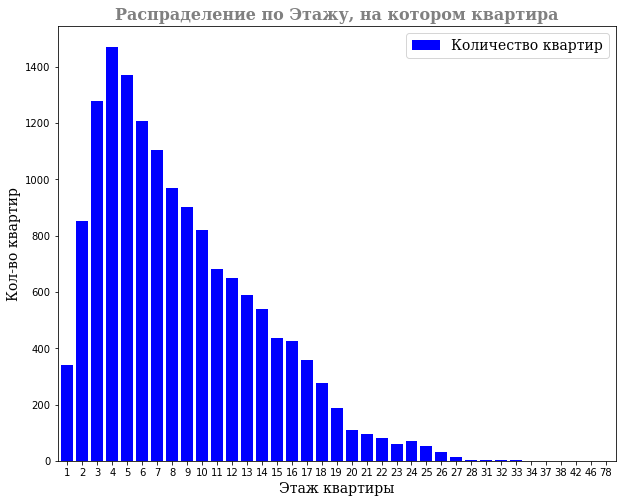

In [61]:
fig, ax1 = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(10, 8)

floors.plot(ax = ax1, kind = 'bar', rot=0, logy=False, color = 'blue', width=0.8, label="Количество квартир")  
ax1.set_title("Распраделение по Этажу, на котором квартира", fontdict=title_font) 
ax1.set_xlabel("Этаж квартиры", fontdict=label_font)
ax1.set_ylabel("Кол-во квартир", fontdict=label_font)
ax1.legend(loc="upper right", prop=legend_font);

In [62]:
# 2.Floor: Last_floor vs Others
df['Last_floor']=0
df.loc[df.Floor==df.HouseFloor, 'Last_floor'] = 1

In [63]:
lastfloor = df.Last_floor.value_counts()

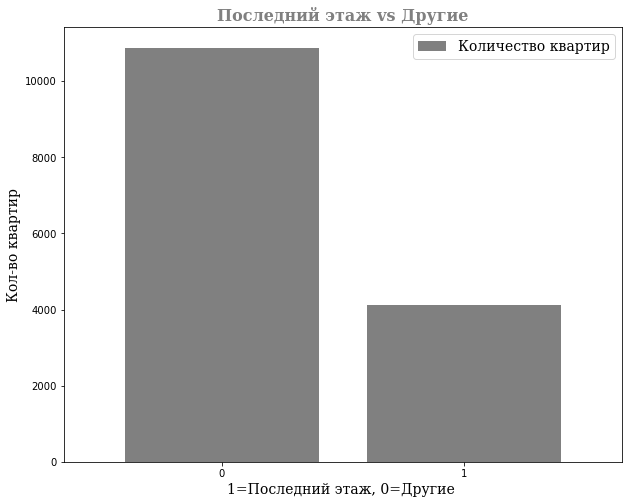

In [64]:
fig, ax1 = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(10, 8)

lastfloor.plot(ax = ax1, kind = 'bar', rot=0, color = 'grey', width=0.8, label="Количество квартир")  
ax1.set_title("Последний этаж vs Другие", fontdict=title_font) 
ax1.set_xlabel("1=Последний этаж, 0=Другие ", fontdict=label_font)
ax1.set_ylabel("Кол-во квартир", fontdict=label_font)
ax1.legend(loc="upper right", prop=legend_font);

In [65]:
# 3.HouseYear: Group by 20 years
df['HouseYear_Decade']=0 

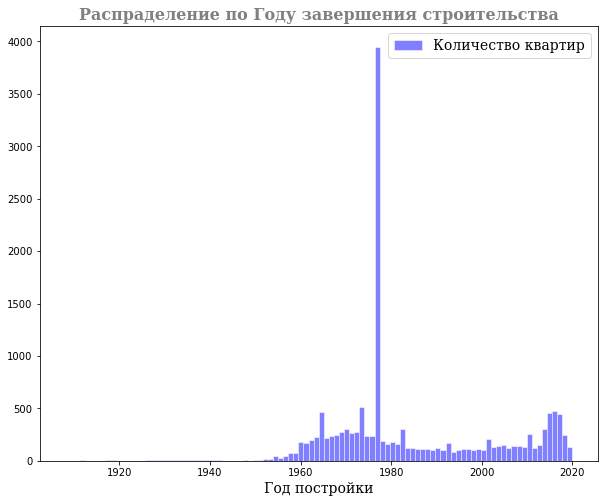

In [66]:
fig, ax1 = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(10, 8)
ax1.hist(df.HouseYear, label="Количество квартир", bins=100, color = "blue", ec="white", alpha=0.5) #, density=True)
ax1.set_title("Распраделение по Году завершения строительства", fontdict=title_font) 
ax1.set_xlabel("Год постройки", fontdict=label_font)
plt.legend(loc="upper right", prop=legend_font)
plt.show()

In [67]:
print(f'Согласно данным - Самый распостранённый Год завершения строительства: {df.HouseYear.mode()[0]}')
print(f'В этот год было построено {len(df.loc[df.HouseYear == df.HouseYear.mode()[0]])} квартиры')
print(f'Это {len(df.loc[df.HouseYear == df.HouseYear.mode()[0]]) / len(df) :.0%} от всех квартир за 100-летний период')
print('Очевидно, что данная информация не является корректной')

Согласно данным - Самый распостранённый Год завершения строительства: 1977
В этот год было построено 3951 квартиры
Это 26% от всех квартир за 100-летний период
Очевидно, что данная информация не является корректной


In [68]:
df.loc[(df.HouseYear==1977), 'HouseYear_Decade'] = 0 
df.loc[(df.HouseYear<=1919), 'HouseYear_Decade'] = 1                         # <=1919
df.loc[(df.HouseYear>=1920) & (df.HouseYear<=1939), 'HouseYear_Decade'] = 2  # 1920-1939
df.loc[(df.HouseYear>=1940) & (df.HouseYear<=1959), 'HouseYear_Decade'] = 3  # 1940-1959
df.loc[((df.HouseYear>=1960) & (df.HouseYear<=1976))|(df.HouseYear==1978)|(df.HouseYear==1979), 'HouseYear_Decade'] = 4  # 1960-1979 без 1977
df.loc[(df.HouseYear>=1980) & (df.HouseYear<=1999), 'HouseYear_Decade'] = 5  # 1980-1999
df.loc[(df.HouseYear>=2000), 'HouseYear_Decade'] = 6                        # >=2000

In [69]:
years = df.HouseYear_Decade.value_counts().sort_index()
ind = ['1977', '<=1919', '1920-1939', '1940-1959', '1960-1979', '1980-1999', '>=2000']
years.index = ind

In [70]:
color = ['grey','green','green','green','green','green','green']

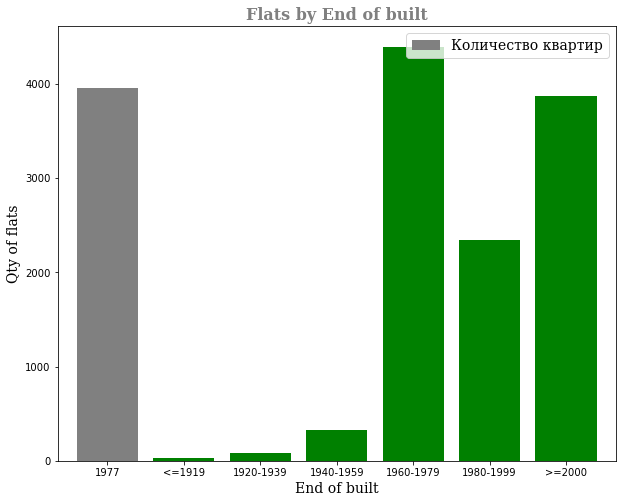

In [71]:
fig, ax1 = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(10, 8)
years.plot(ax = ax1, kind = 'bar', rot=0, color = color, width=0.8, label="Количество квартир")  
ax1.set_title("Flats by End of built", fontdict=title_font) 
ax1.set_xlabel("End of built", fontdict=label_font)
ax1.set_ylabel("Qty of flats", fontdict=label_font)
ax1.legend(loc="upper right", prop=legend_font);

In [72]:
# 4.HouseYear: Outlier 1977 year
df['HouseYear_1977']=0 
df.loc[(df.HouseYear==1977), 'HouseYear_1977'] = 1 

In [73]:
df.head(5)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Helthcare_2,Shops_1,Shops_2,LifeSquare_miss,Floor_incorrect,Healthcare_1_miss,Firts_floor,Last_floor,HouseYear_Decade,HouseYear_1977
0,27,3.000,115.027,80.216,10.000,4,10,2014,0.075,B,...,0,0,B,True,0,True,0,0,6,0
1,22,1.000,39.833,23.169,8.000,7,8,1966,0.119,B,...,1,0,B,False,0,False,0,0,4,0
2,1,3.000,78.342,47.672,10.000,2,17,1988,0.026,B,...,3,1,B,False,0,False,0,0,5,0
3,1,1.000,40.410,30.100,1.000,10,22,1977,0.007,B,...,0,1,B,True,0,True,0,0,0,1
4,94,2.000,64.285,38.563,9.000,16,16,1972,0.283,B,...,0,6,B,False,0,True,0,1,4,0


In [74]:
# 5.HouseFloor: Most common houses by Floor
stages = df.HouseFloor.value_counts().sort_index()

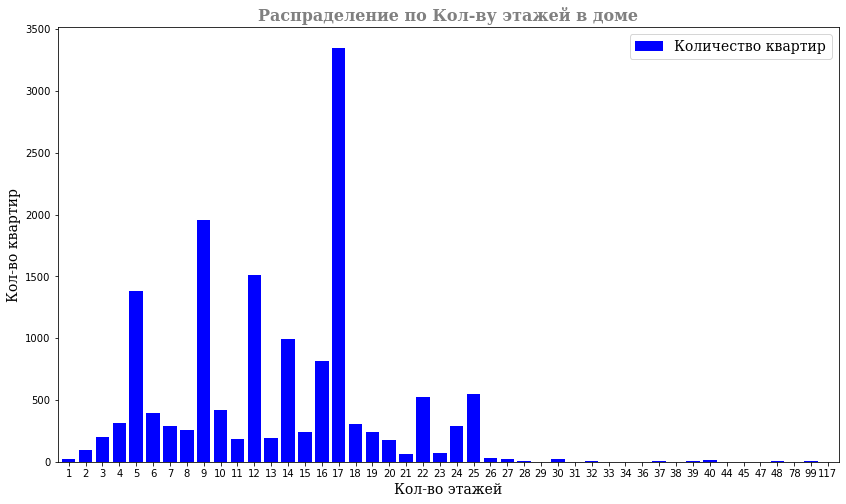

In [75]:
fig, ax1 = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(14, 8)

stages.plot(ax = ax1, kind = 'bar', rot=0, logy=False, color = 'blue', width=0.8, label="Количество квартир")  
ax1.set_title("Распраделение по Кол-ву этажей в доме", fontdict=title_font) 
ax1.set_xlabel("Кол-во этажей", fontdict=label_font)
ax1.set_ylabel("Кол-во квартир", fontdict=label_font)
ax1.legend(loc="upper right", prop=legend_font);

Согласно графику по кол-ву выделяются следующие дома:
- 5 этажей,
- 9 этажей,
- 12 этажей,
- 17 этажей

In [76]:
#Добавим для них отдельные фичи:

df['Stage_05']=0
df['Stage_09']=0
df['Stage_12']=0
df['Stage_17']=0

df.loc[df.HouseFloor==5,  'Stage_05'] = 1
df.loc[df.HouseFloor==9,  'Stage_09'] = 1
df.loc[df.HouseFloor==12, 'Stage_12'] = 1
df.loc[df.HouseFloor==17, 'Stage_17'] = 1

In [77]:
# 6.Room: 1 Room vs Others
df.loc[df.Rooms==17, 'Rooms'] = 1 # LifeSquare=32
df['Rooms'] = df['Rooms'] .astype('int')
rooms = df.Rooms.value_counts().sort_index()

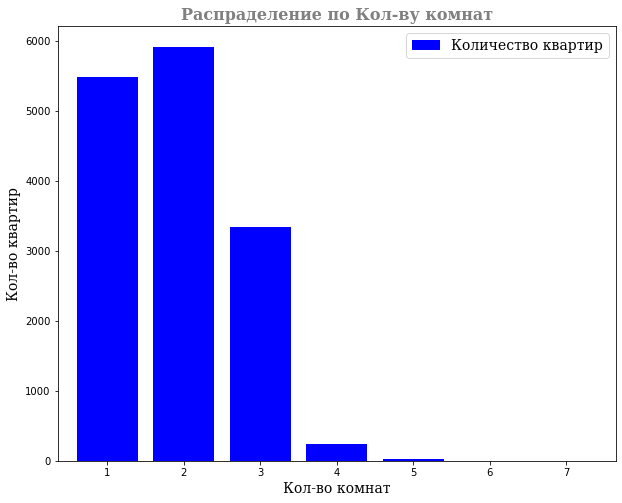

In [78]:
fig, ax1 = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(10, 8)

rooms.plot(ax = ax1, kind = 'bar', rot=0, logy=False, color = 'blue', width=0.8, label="Количество квартир")  
ax1.set_title("Распраделение по Кол-ву комнат", fontdict=title_font) 
ax1.set_xlabel("Кол-во комнат", fontdict=label_font)
ax1.set_ylabel("Кол-во квартир", fontdict=label_font)
ax1.legend(loc="upper right", prop=legend_font);

In [79]:
# 7.Kitchen Floor: NoKitchen vs Others
df['Kitchen_no'] =0
df.loc[df.KitchenSquare==0, 'Kitchen_no'] = 1

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   DistrictId         15000 non-null  int64  
 1   Rooms              15000 non-null  int32  
 2   Square             15000 non-null  float64
 3   LifeSquare         15000 non-null  float64
 4   KitchenSquare      15000 non-null  float64
 5   Floor              15000 non-null  int64  
 6   HouseFloor         15000 non-null  int64  
 7   HouseYear          15000 non-null  int64  
 8   Ecology_1          15000 non-null  float64
 9   Ecology_2          15000 non-null  object 
 10  Ecology_3          15000 non-null  object 
 11  Social_1           15000 non-null  int64  
 12  Social_2           15000 non-null  int64  
 13  Social_3           15000 non-null  int64  
 14  Healthcare_1       15000 non-null  float64
 15  Helthcare_2        15000 non-null  int64  
 16  Shops_1            150

### Unique

In [81]:
df.nunique().sort_values(ascending=False)

Square               14997
LifeSquare           14992
DistrictId             212
Social_2               144
Ecology_1              131
HouseYear              103
Healthcare_1            80
Social_1                51
HouseFloor              46
Floor                   37
Social_3                30
KitchenSquare           26
Shops_1                 16
Rooms                    7
HouseYear_Decade         7
Helthcare_2              7
Ecology_3                2
Shops_2                  2
LifeSquare_miss          2
Floor_incorrect          2
Healthcare_1_miss        2
Firts_floor              2
Last_floor               2
Ecology_2                2
HouseYear_1977           2
Stage_05                 2
Stage_09                 2
Stage_12                 2
Stage_17                 2
Kitchen_no               2
dtype: int64

In [82]:
di = { "A": 1, "B":0}
cols_bin = ('Ecology_2', 'Ecology_3', 'Shops_2')
for col in cols_bin:
    df[col] = df[col].map(di)

In [83]:
cols_bin = ('Floor_incorrect','Ecology_2', 'Ecology_3', 'Shops_2','Stage_05','Stage_09','Stage_12','Stage_17',\
            'Firts_floor', 'Last_floor', 'HouseYear_1977','Kitchen_no')
for col in cols_bin:
    df[col] = df[col].astype('bool')

In [84]:
cols_str = ('DistrictId','Social_2', 'Ecology_1', 'HouseYear', 'Healthcare_1', 'Social_1', 'HouseFloor', 'Floor', 'Social_3')
for col in cols_str:
    df[col] = df[col].astype(str)

In [85]:
from sklearn.preprocessing import LabelEncoder
cols_lab = ('DistrictId','Social_2', 'Ecology_1', 'HouseYear', 'Healthcare_1', 'Social_1', 'HouseFloor', \
            'Floor', 'Social_3', 'HouseYear_Decade')
for col in cols_lab:
    lbl = LabelEncoder() 
    lbl.fit(list(df[col].values)) 
    df[col] = lbl.transform(list(df[col].values))

In [86]:
cols_dummy = ['HouseYear_Decade', 'Helthcare_2', 'Rooms']
encoded_columns = pd.get_dummies(df[cols_dummy])

df = df.drop(cols_dummy, axis=1)
df = df.join(encoded_columns)

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   DistrictId         15000 non-null  int32  
 1   Square             15000 non-null  float64
 2   LifeSquare         15000 non-null  float64
 3   KitchenSquare      15000 non-null  float64
 4   Floor              15000 non-null  int32  
 5   HouseFloor         15000 non-null  int32  
 6   HouseYear          15000 non-null  int32  
 7   Ecology_1          15000 non-null  int32  
 8   Ecology_2          15000 non-null  bool   
 9   Ecology_3          15000 non-null  bool   
 10  Social_1           15000 non-null  int32  
 11  Social_2           15000 non-null  int32  
 12  Social_3           15000 non-null  int32  
 13  Healthcare_1       15000 non-null  int32  
 14  Shops_1            15000 non-null  int64  
 15  Shops_2            15000 non-null  bool   
 16  LifeSquare_miss    150

In [88]:
feature_names_for_stand = df.select_dtypes(include=['int32', 'int64', 'float64']).columns.tolist()
feature_names_for_stand

['DistrictId',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Shops_1',
 'HouseYear_Decade',
 'Helthcare_2',
 'Rooms']

In [89]:
scaler = StandardScaler()
stand_features = scaler.fit_transform(df[feature_names_for_stand])

In [90]:
df[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)

In [91]:
df.describe()

,DistrictId,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Shops_1,HouseYear_Decade,Helthcare_2,Rooms
count,15000.000,15000.000,15000.000,15000.000,15000.000,15000.000,15000.000,15000.000,15000.000,15000.000,15000.000,15000.000,15000.000,15000.000,15000.000,15000.000
mean,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
min,-1.950,-2.893,-2.215,-1.469,-1.496,-1.221,-3.636,-1.567,-1.751,-1.564,-0.893,-1.069,-0.883,-1.557,-0.886,-1.102
25%,-0.568,-0.758,-0.750,-1.211,-1.034,-0.703,-0.585,-0.846,-0.768,-1.054,-0.893,-0.719,-0.674,-1.557,-0.886,-1.102
50%,0.186,-0.189,-0.205,0.080,0.121,-0.639,-0.422,-0.151,-0.065,0.100,-0.544,-0.719,-0.258,0.182,-0.215,0.128
75%,0.689,0.513,0.554,0.854,0.968,1.300,0.885,0.880,0.919,0.876,0.853,0.769,0.368,1.052,0.457,0.128
max,1.365,8.779,7.790,4.983,1.276,1.688,1.920,1.781,1.762,1.609,2.483,2.388,3.912,1.052,3.143,6.278


## 4. Train test split

In [92]:
X = df[:ntrain]
y = price
test = df[ntrain:]

In [93]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=2022)

In [94]:
def evaluate_preds(true_values, pred_values, save=False):
    """Quality of model evaluation. Preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([11, 13.5], [11, 13.5], linestyle='--', color='black')  # line where  true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

In [95]:
y.describe()

count   10000.000
mean       12.190
std         0.407
min        10.988
25%        11.944
50%        12.167
75%        12.426
max        13.359
Name: Price, dtype: float64

## 5. ML modelling

#### 5.1 DecisionTreeRegressor

In [96]:
max_depth_arr = np.arange(2, 20)

for val in max_depth_arr:
    dt_model = DecisionTreeRegressor(criterion='mse', 
                                 max_depth=val, 
                                 min_samples_leaf=1,
                                 random_state=2022)
    dt_model.fit(X_train, y_train)
    
    y_pred = dt_model.predict(X_valid)
    y_train_pred = dt_model.predict(X_train)
    
    R2_valid = round(r2(y_valid, y_pred), 3)
    R2_train = round(r2(y_train, y_train_pred), 3)
                   
    print(f'max_depth = {val:.3f}, R2_valid = {R2_valid:.3f}, R2_train = {R2_train:.3f}')

max_depth = 2.000, R2_valid = 0.385, R2_train = 0.353
max_depth = 3.000, R2_valid = 0.491, R2_train = 0.454
max_depth = 4.000, R2_valid = 0.558, R2_train = 0.521
max_depth = 5.000, R2_valid = 0.599, R2_train = 0.572
max_depth = 6.000, R2_valid = 0.628, R2_train = 0.618
max_depth = 7.000, R2_valid = 0.654, R2_train = 0.672
max_depth = 8.000, R2_valid = 0.655, R2_train = 0.723
max_depth = 9.000, R2_valid = 0.634, R2_train = 0.765
max_depth = 10.000, R2_valid = 0.621, R2_train = 0.802
max_depth = 11.000, R2_valid = 0.597, R2_train = 0.839
max_depth = 12.000, R2_valid = 0.577, R2_train = 0.870
max_depth = 13.000, R2_valid = 0.561, R2_train = 0.897
max_depth = 14.000, R2_valid = 0.539, R2_train = 0.919
max_depth = 15.000, R2_valid = 0.510, R2_train = 0.939
max_depth = 16.000, R2_valid = 0.500, R2_train = 0.957
max_depth = 17.000, R2_valid = 0.508, R2_train = 0.967
max_depth = 18.000, R2_valid = 0.505, R2_train = 0.976
max_depth = 19.000, R2_valid = 0.512, R2_train = 0.986


In [97]:
dt_model = DecisionTreeRegressor(criterion='mse', 
                                 max_depth=8, 
                                 min_samples_leaf=1,
                                 random_state=2022)
dt_model.fit(X_train, y_train)

y_pred = dt_model.predict(X_valid)

R2_valid = round(r2(y_valid, y_pred), 3)
R2_valid

0.655

R2:	0.723
RMSE:	0.215
MSE:	0.046


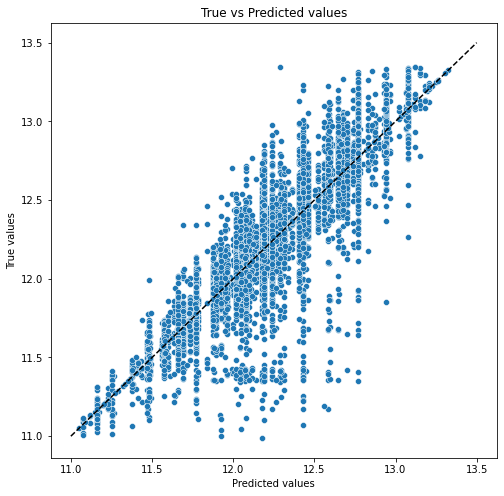

In [98]:
dt_model = DecisionTreeRegressor(criterion='mse', 
                                 max_depth=8, 
                                 min_samples_leaf=1,
                                 random_state=2022)
dt_model.fit(X_train, y_train)

y_train_preds = dt_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.655
RMSE:	0.237
MSE:	0.056


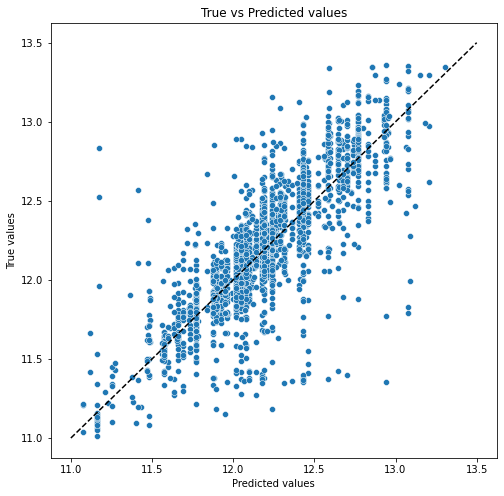

In [99]:
y_valid_preds = dt_model.predict(X_valid)
evaluate_preds(y_valid, y_valid_preds)

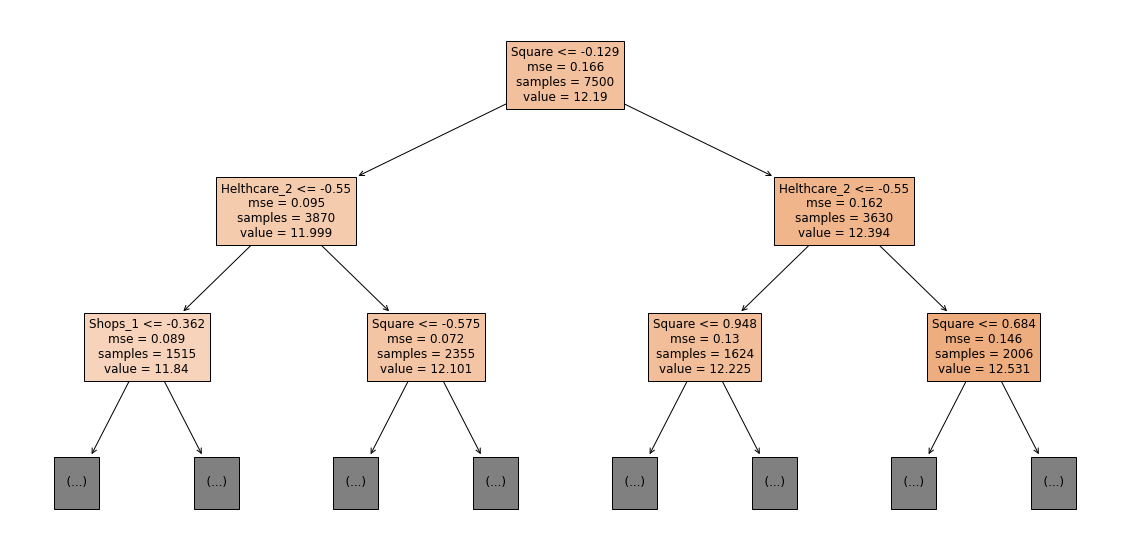

In [100]:
plt.figure(figsize=(20,10))
plot_tree(dt_model, feature_names=X_train.columns, filled = True, max_depth=2);

#### 5.2 Random Forest

R2:	0.699
RMSE:	0.224
MSE:	0.05


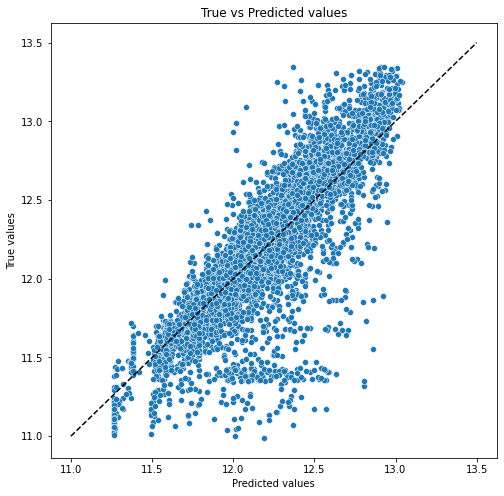

In [101]:
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=20, 
                                 min_samples_leaf=30,
                                 random_state=42,
                                 n_estimators=100 
                                 )

rf_model.fit(X_train, y_train)
y_train_preds = rf_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.701
RMSE:	0.22
MSE:	0.048


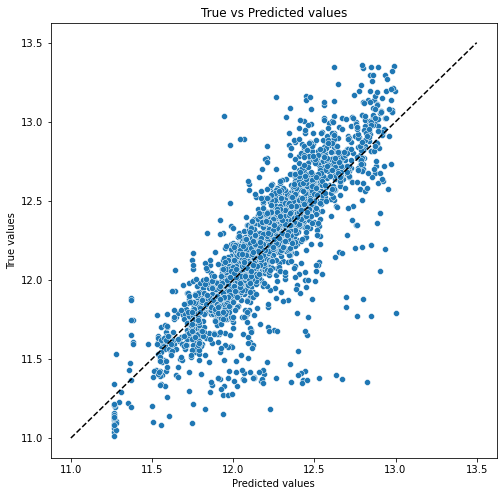

In [102]:
y_valid_preds = rf_model.predict(X_valid)
evaluate_preds(y_valid, y_valid_preds)

##### RF Hyperparameters

In [103]:
# parameters = {
#     'n_estimators': [150, 200, 250],
#     'max_features': np.arange(5, 9),
#     'max_depth': np.arange(5, 10),
# }

In [104]:
# rf_best = GridSearchCV(
#     estimator=RandomForestRegressor(random_state=2022),
#     param_grid=parameters,
#     scoring='neg_mean_squared_error',
#     cv=5
# )

In [105]:
# rf_best.fit(X, y)

In [106]:
# rf_best.best_params_

R2:	0.776
RMSE:	0.193
MSE:	0.037


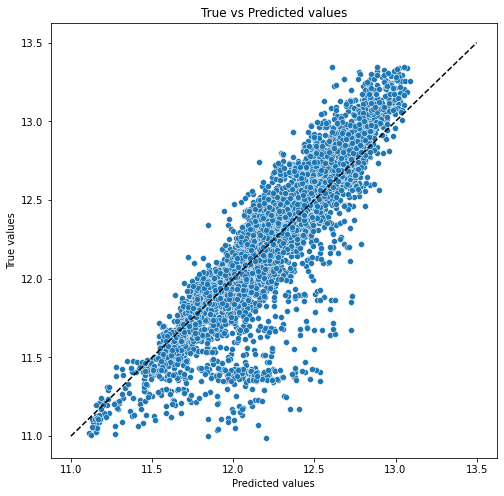

In [107]:
rf_best = RandomForestRegressor(max_depth=9, max_features=8, n_estimators=250)

rf_best.fit(X_train, y_train)

y_train_preds = rf_best.predict(X_train)
evaluate_preds(y_train, y_train_preds)

#### 5.3 Gradient Boosting Regreiission

R2:	0.869
RMSE:	0.147
MSE:	0.022


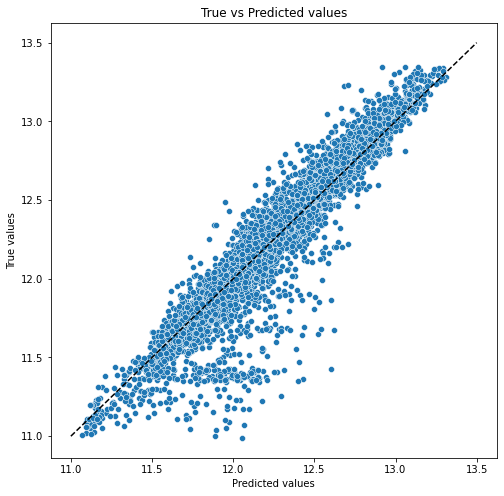

In [108]:
#Gradient Boosting Regreiission :
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=10,
                                     random_state=42,  
                                     n_estimators=100)
gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.754
RMSE:	0.2
MSE:	0.04


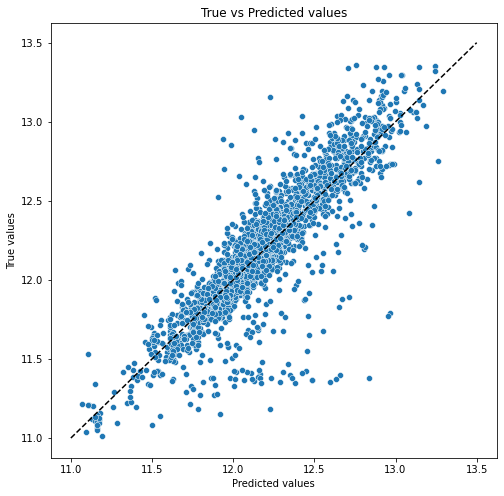

In [109]:
y_valid_preds = gb_model.predict(X_valid)
evaluate_preds(y_valid, y_valid_preds)

##### GBR Hyperparameters

In [110]:
# params = {'n_estimators':[50, 100, 200, 400], 
#           'max_depth':[3, 5, 7, 10]}

# gs = GridSearchCV(gb_model, params, 
#                   scoring='r2', # метрика 
#                   cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
#                            random_state=21, 
#                            shuffle=True),
#                   n_jobs=-1
#                   )
# gs.fit(X, y)

In [111]:
# gs.best_params_

R2:	0.755
RMSE:	0.199
MSE:	0.04


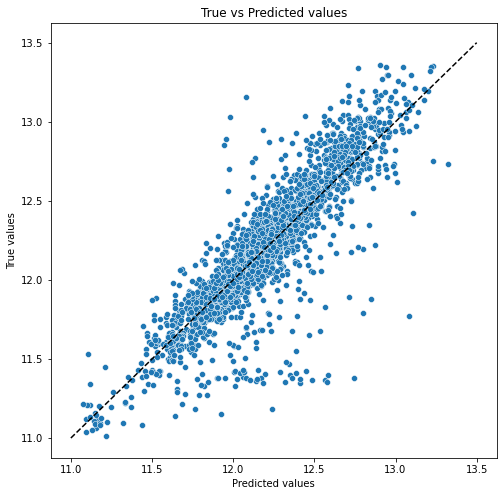

In [112]:
gs_best = GradientBoostingRegressor(criterion='mse',
                                        max_depth=5,
                                        min_samples_leaf=10,
                                        random_state=42,
                                        n_estimators=200)

gs_best.fit(X_train, y_train)

y_valid_preds = gs_best.predict(X_valid)
evaluate_preds(y_valid, y_valid_preds)

## 6.  Final Prediction and Feature importance

In [113]:
gs_best = GradientBoostingRegressor(criterion='mse',
                                        max_depth=5,
                                        min_samples_leaf=10,
                                        random_state=42,
                                        n_estimators=200)

gs_best.fit(X, y)

y_test_preds = gs_best.predict(test)

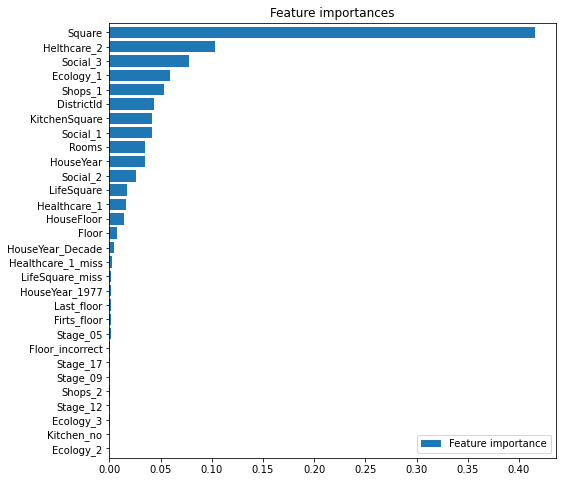

In [114]:
importance = gs_best.feature_importances_
feature_importance = pd.Series(importance, index=df.columns).sort_values()

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(8, 8)
feature_importance.plot(kind='barh', ax=ax, width=0.8, label="Feature importance")
ax.set_title("Feature importances")
ax.legend(loc="lower right");

### Submission

In [115]:
# os.chdir(r'C:\Data\GB\Python_Numpy\0_Real_estate\sub')
# sub = pd.DataFrame()
# sub['Id'] = test_ID
# sub['Price'] = np.expm1(y_test_preds)
# sub.to_csv('sub_3.csv',index=False)